

## Definition of the J2-problem

\begin{equation}
\begin{split}
\frac{d}{dt} q &= v, \quad q(0) = q_0,\\
\frac{d}{dt} v &= -\frac{\mu}{r^3} q -  \nabla V(q), \quad v(0)=v_0
\end{split}
\tag{1}
\end{equation}

where 

\begin{equation}
q = \left(
\begin{matrix}
x\\
y\\
z
\end{matrix}
\right), \quad 
v = \left(
\begin{matrix}
\dot x\\
\dot y\\
\dot z
\end{matrix}
\right), \quad r=\|q\|, 
\end{equation}

and

\begin{equation}
V(q) =  \frac{C}{2\, r^3} \,\left(3\, \sin^2\theta -1 \right), \quad \sin\theta = \frac{z}{r}, \quad C=J_2\, \mu\, R_e^2.
\end{equation}

The state vector of the system is 

$$u=(x,y,z,\dot x, \dot y, \dot z).$$

The energy 

$$
E(u) = \frac12\, \|v\|^2 - \frac{\mu}{r} \left( 1 + \frac{\epsilon}{2} \frac{R^2}{r^2} \left(  1 - 3\, \frac{z^2}{r^2}  \right)\right)
$$

is a conserved quantity.

In [1]:
function Energy(u,p)
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    q = u[1:3]
    v = u[4:6]
    r = norm(q)
    v2 = dot(v,v)
    sinth2 = (u[3]/r)^2
    aux = (R/r)^2
    return 0.5*v2 - μ/r * (1 + 0.5*ϵ*aux * (1 - 3*sinth2))
end

function J2ODE!(du,u,p,t)
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux1 = -μ/(r*r2)
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = ϵ*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    du[4]=aux3*x
    du[5]=aux3*y
    du[6]=aux4*z
    return nothing
end


J2ODE! (generic function with 1 method)

<a href="#top">Hasierara</a>

## Loading packages and functions

In [2]:
using LinearAlgebra
using Plots
using SIMD
include("../src/IRK16_SIMD.jl")
include("../src/IRK16_seq.jl")
using BenchmarkTools

##### <a href="#top">Hasierara</a>

## Initial value problem: J2-problem (in physical time)

In [3]:
q0 = [0., 9486.934364319237, 0.]
v0 = [6.595352441436386, 0., 1.6488381103590966]
u0 = vcat(q0,v0)
μ = 398600.8
R = 6378.135
ϵ = 0.0010826157
p =  [μ, R, ϵ]
E0 = Energy(u0,p)

-18.91737400006957

In [15]:
t0 = 0.
birak = 10000
tF = birak*10770.5
dt = (tF-t0)/(10*birak)

n = 1000
#n = 5

m = convert(Int64,ceil(abs(tF-t0)/(n*dt)))
n = convert(Int64,ceil(abs(tF-t0)/(m*dt))) # Number of macro-steps (Output is saved for n+1 time values)
dt = (tF-t0)/(n*m)
println("dt = $dt, n=$n, m=$m")

rbits = 0
itermax = 100

for k in 1:2
  println(k," execution CPU-Times")
  @time sol1=IRK16(u0, t0, tF, n, m, J2ODE!, p,  initial_interp=true, rbits=rbits,
                   itermax=itermax);

@time sol3=IRK16_SIMD(u0, t0, tF, n, m, J2ODE!, p,  initial_interp=true, 
                 itermax=itermax);
end

dt = 1077.05, n=1000, m=100
1 execution CPU-Times
  1.955198 seconds (1.54 k allocations: 183.055 KiB)
  0.455779 seconds (1.52 k allocations: 182.883 KiB)
2 execution CPU-Times
  1.944640 seconds (1.54 k allocations: 183.055 KiB)
  0.480910 seconds (1.52 k allocations: 182.883 KiB)


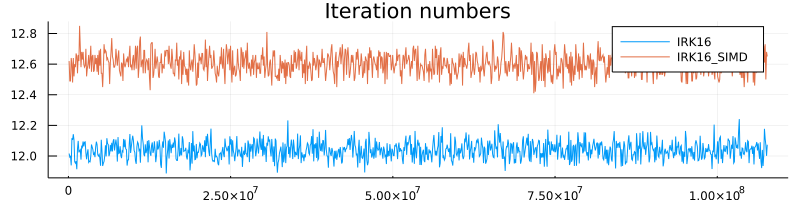

In [18]:
plot(sol1.t[2:end], sol1.iter[2:end], title="Iteration numbers", size=(800,200), label="IRK16")
plot!(sol3.t[2:end], sol3.iter[2:end],  label="IRK16_SIMD")

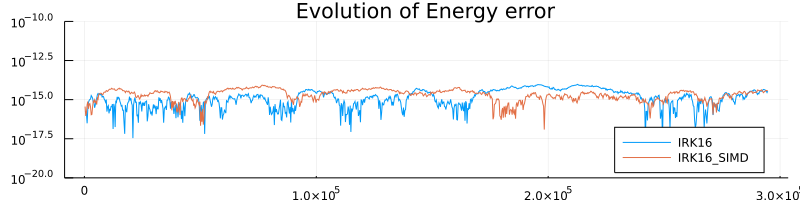

In [9]:
E0 = Energy(BigFloat.(u0),p)
yrange = (1e-20,1e-10)
year = 365.5
epsilon = eps(1e-3)
tt = sol1.t[2:end]/year

energia_erroreak1 = [Float64.(abs(Energy(BigFloat.(u),p)/E0-1)) for u in sol1.u[2:end]]
energia_erroreak3 = [Float64.(abs(Energy(BigFloat.(u),p)/E0-1)) for u in sol3.u[2:end]]


plot(title="Evolution of Energy error",
         yscale=:log10, ylims=yrange, legend=:bottomright, size=(800,200))
plot!(tt, energia_erroreak1, label="IRK16")
plot!(tt,  energia_erroreak3, label="IRK16_SIMD")


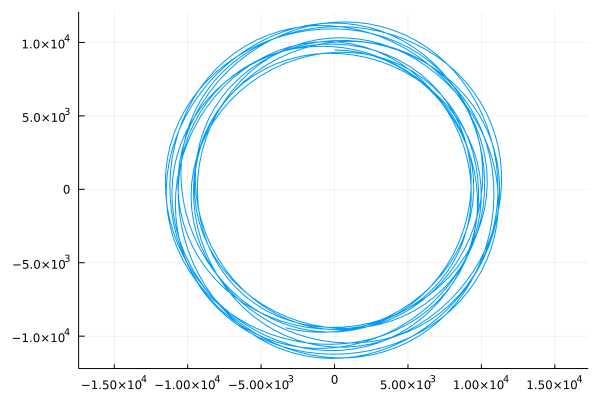

In [7]:
xx = [u[1] for u in sol1.u]
yy = [u[2] for u in sol1.u]
plot(xx,yy, aspect_ratio=1, legend=false)

In [8]:
uu = rand(8,6)
U = Vec8Vector(uu)
dU = deepcopy(U)

@btime J2ODE!(dU,U,p,0.)

u = uu[1,:]
du = similar(u)


@btime J2ODE!(du,u,p,0.)

dif = Float64[]
for i in 1:8
    J2ODE!(du,U.data[i,:],p,0.)
    push!(dif, norm(du-dU.data[i,:])) 
end
norm(dif)

  150.719 ns (0 allocations: 0 bytes)
  51.889 ns (0 allocations: 0 bytes)


0.0